## Refer: https://github.com/hzwer/ECCV2022-RIFE/tree/main
### download pretrained weights into `train_log/` as per README

## Use WSL gputf env, because main code requires torchvision, but preprocess image requires other models present in gputf

In [1]:
# !pip freeze

In [69]:
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import os

In [3]:
import fix_images

2025-04-24 18:54:03.044155: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-24 18:54:03.044325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-24 18:54:03.093906: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-24 18:54:03.176182: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-24 18:54:03.985400: W tensorflow/compiler/tf2

Model file already exists


In [4]:
# check gpu availability
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
print('torch:', torch.__version__)
print('CUDA toolkit:', torch.version.cuda)

torch: 2.5.1+cu124
CUDA toolkit: 12.4


In [ ]:
# read files from `input_dir`
input_dir = Path('input_frames/shahrukh-khan')
output_dir = Path('output_frames_rife')
temp_dir = Path('temp_frames_rife')

In [ ]:

# delete temp_dir if it exists
if temp_dir.exists():
    for item in temp_dir.iterdir():
        if item.is_file():
            item.unlink()
    temp_dir.rmdir()
temp_dir.mkdir(exist_ok=False)

output_dir.mkdir(exist_ok=True)
input_files = list(input_dir.glob('*.jpg'))
# sort files using natsort
# import natsorted
from natsort import natsorted
input_files = natsorted(input_files, key=lambda x: x.stem)

In [70]:
# Display all files as tiles
def display_images_in_tiles(image_paths, cols=4):
    images = [cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB) for path in image_paths]
    rows = (len(images) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    for ax in axes.flatten():
        ax.axis('off')
    for i, img in enumerate(images):
        ax = axes.flatten()[i]
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

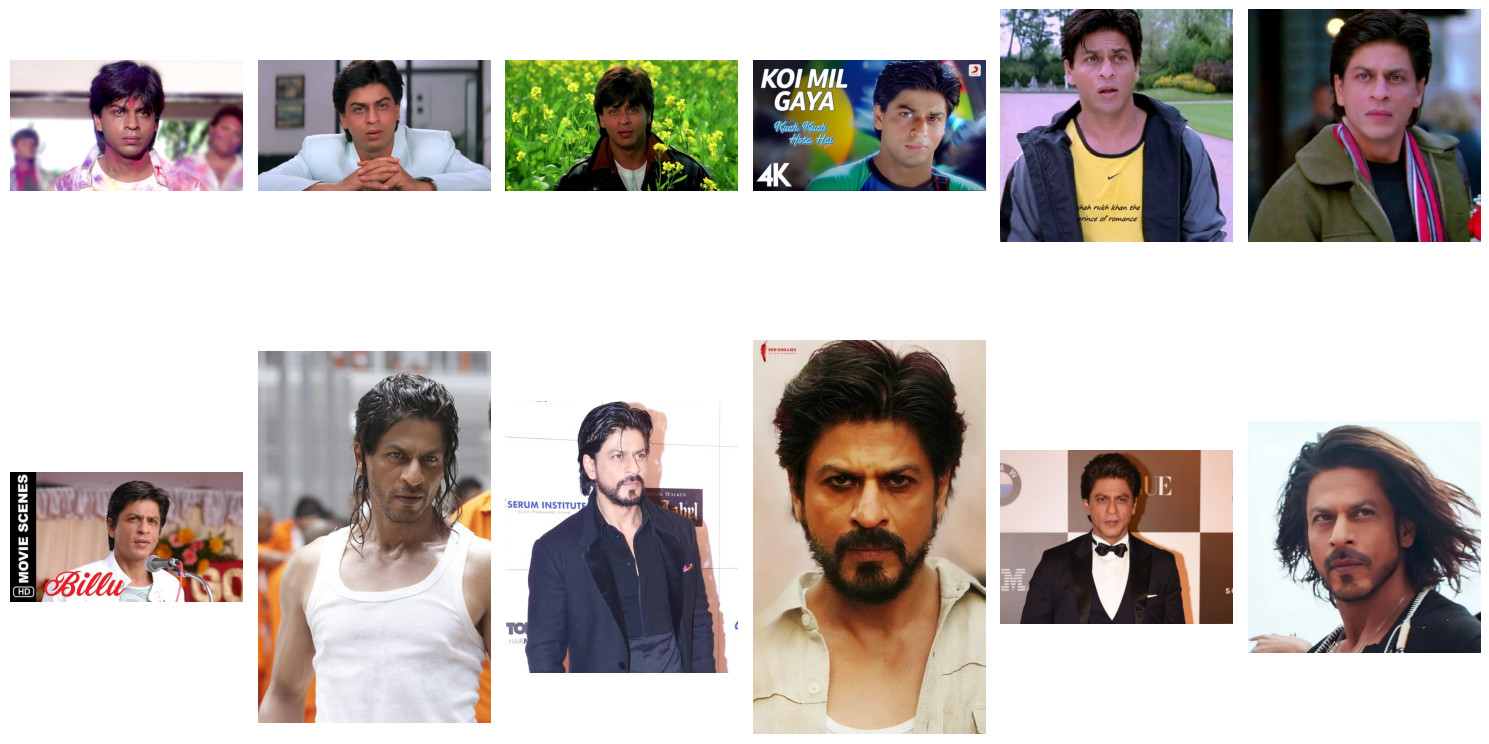

In [71]:
display_images_in_tiles(input_files, cols=6)

## Preprocess Images
#### Remove background, detect face, crop, resize

In [7]:
reference_path = None
for f in tqdm(input_files, desc='Preparing images'):
        output_file = (temp_dir / Path(f).name).as_posix()
        if not reference_path:
            reference_path = f
        fix_images.process_face_image(
            f,
            output_file,
            reference_path=str(reference_path),
            background_color=(255, 255, 255),  # White background
            save_bbox_preview=False,
            fix_lighting=False,
            )


Preparing images:   0%|          | 0/12 [00:00<?, ?it/s]INFO:fix_images:Processing image: input_frames/shahrukh-khan/1992_deewana.jpg
INFO:fix_images:Image loaded successfully
libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1745501056.709215   24117 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
INFO:fix_images:Face detected successfully
INFO:fix_images:Image cropped and centered
INFO:fix_images:Image resized
INFO:fix_images:Ba

In [9]:
import os
os.getcwd()

'/home/sparsh/programming/ml/ai_timelapse'

In [10]:
files = list(temp_dir.glob('*.jpg'))
files = natsorted(files, key=lambda x: x.stem)

In [26]:
for x in files:
    print(x)

temp_frames_rife/1992_deewana.jpg
temp_frames_rife/1993_baazigar.jpg
temp_frames_rife/1995_ddlj.jpg
temp_frames_rife/1998_kuch_kuch_hota_hai.jpg
temp_frames_rife/2001_kbkg.jpg
temp_frames_rife/2006_kabh_alvida.jpg
temp_frames_rife/2009_billu.jpg
temp_frames_rife/2011_don.jpg
temp_frames_rife/2014_hny.jpg
temp_frames_rife/2017_raees.jpg
temp_frames_rife/2019_media.jpg
temp_frames_rife/2023_pathan.jpg


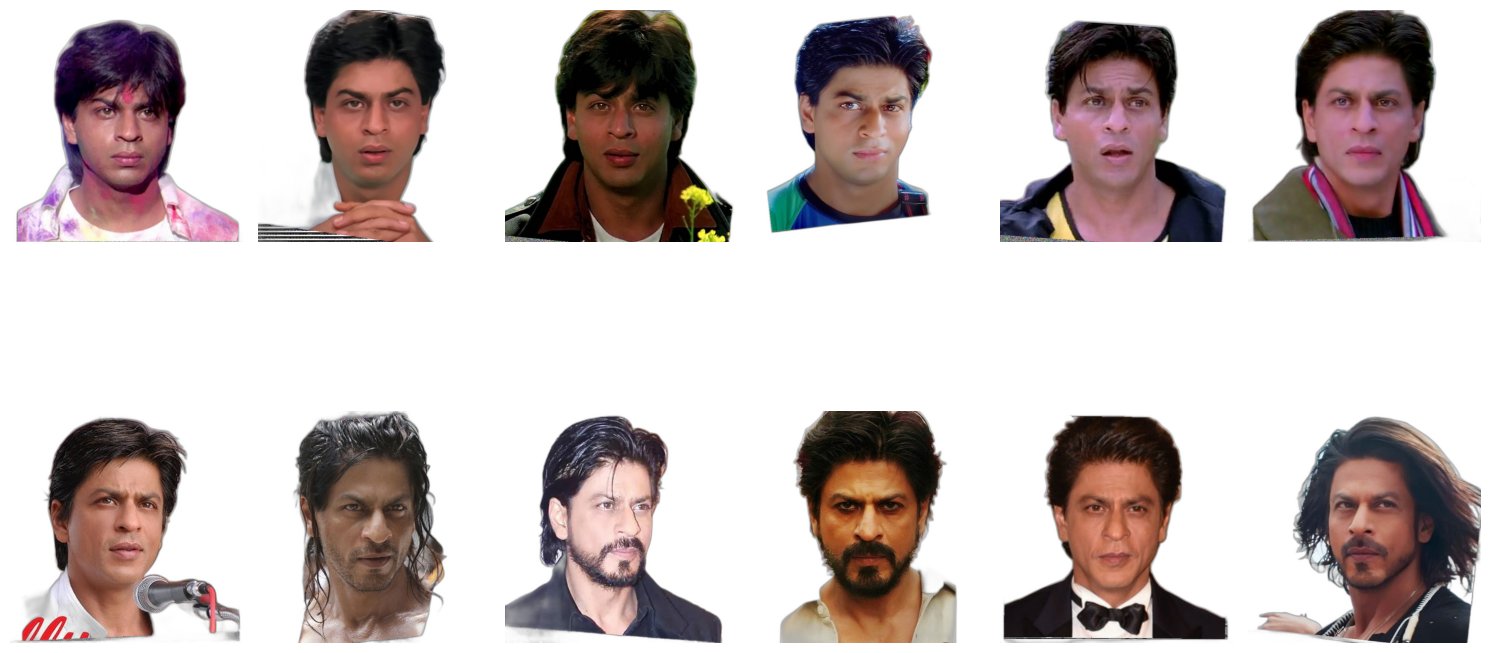

In [ ]:
display_images_in_tiles(files, cols=6)

In [ ]:
import os
import cv2
import torch
import argparse
from torch.nn import functional as F
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_grad_enabled(False)
if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True

# parser = argparse.ArgumentParser(description='Interpolation for a pair of images')
# parser.add_argument('--img', dest='img', nargs=2, required=True)
# parser.add_argument('--exp', default=4, type=int)
# parser.add_argument('--ratio', default=0, type=float, help='inference ratio between two images with 0 - 1 range')
# parser.add_argument('--rthreshold', default=0.02, type=float, help='returns image when actual ratio falls in given range threshold')
# parser.add_argument('--rmaxcycles', default=8, type=int, help='limit max number of bisectional cycles')
# parser.add_argument('--model', dest='modelDir', type=str, default='train_log', help='directory with trained model files')

# args = parser.parse_args()

# make args as object with these fields
class Args:
    def __init__(self):
        self.img = []
        self.exp = 4
        self.ratio = 0
        self.rthreshold = 0.02
        self.rmaxcycles = 8
        self.modelDir = 'train_log'
args = Args()

## Interpolate and Create Video

In [ ]:
import sys
sys.path.append('ECCV2022-RIFE/')

In [ ]:

try:
    try:
        try:
            from model.RIFE_HDv2 import Model
            model = Model()
            model.load_model(args.modelDir, -1)
            print("Loaded v2.x HD model.")
        except:
            from train_log.RIFE_HDv3 import Model
            model = Model()
            model.load_model(args.modelDir, -1)
            print("Loaded v3.x HD model.")
    except:
        from model.RIFE_HD import Model
        model = Model()
        model.load_model(args.modelDir, -1)
        print("Loaded v1.x HD model")
except:
    from model.RIFE import Model
    model = Model()
    model.load_model(args.modelDir, -1)
    print("Loaded ArXiv-RIFE model")
model.eval()
model.device()


Loaded v3.x HD model.


In [60]:

def interpolate_images(args, model):
    if args.img[0].endswith('.exr') and args.img[1].endswith('.exr'):
        img0 = cv2.imread(args.img[0], cv2.IMREAD_COLOR | cv2.IMREAD_ANYDEPTH)
        img1 = cv2.imread(args.img[1], cv2.IMREAD_COLOR | cv2.IMREAD_ANYDEPTH)
        img0 = (torch.tensor(img0.transpose(2, 0, 1)).to(device)).unsqueeze(0)
        img1 = (torch.tensor(img1.transpose(2, 0, 1)).to(device)).unsqueeze(0)

    else:
        img0 = cv2.imread(args.img[0], cv2.IMREAD_UNCHANGED)
        img1 = cv2.imread(args.img[1], cv2.IMREAD_UNCHANGED)
        img0 = (torch.tensor(img0.transpose(2, 0, 1)).to(device) / 255.).unsqueeze(0)
        img1 = (torch.tensor(img1.transpose(2, 0, 1)).to(device) / 255.).unsqueeze(0)

    n, c, h, w = img0.shape
    ph = ((h - 1) // 32 + 1) * 32
    pw = ((w - 1) // 32 + 1) * 32
    padding = (0, pw - w, 0, ph - h)
    img0 = F.pad(img0, padding)
    img1 = F.pad(img1, padding)


    if args.ratio:
        img_list = [img0]
        img0_ratio = 0.0
        img1_ratio = 1.0
        if args.ratio <= img0_ratio + args.rthreshold / 2:
            middle = img0
        elif args.ratio >= img1_ratio - args.rthreshold / 2:
            middle = img1
        else:
            tmp_img0 = img0
            tmp_img1 = img1
            for inference_cycle in range(args.rmaxcycles):
                middle = model.inference(tmp_img0, tmp_img1)
                middle_ratio = ( img0_ratio + img1_ratio ) / 2
                if args.ratio - (args.rthreshold / 2) <= middle_ratio <= args.ratio + (args.rthreshold / 2):
                    break
                if args.ratio > middle_ratio:
                    tmp_img0 = middle
                    img0_ratio = middle_ratio
                else:
                    tmp_img1 = middle
                    img1_ratio = middle_ratio
        img_list.append(middle)
        img_list.append(img1)
    else:
        img_list = [img0, img1]
        for i in range(args.exp):
            tmp = []
            for j in range(len(img_list) - 1):
                mid = model.inference(img_list[j], img_list[j + 1])
                tmp.append(img_list[j])
                tmp.append(mid)
            tmp.append(img1)
            img_list = tmp

    return img_list


In [61]:
# delete output_dir if it exists
if output_dir.exists():
    for item in output_dir.iterdir():
        if item.is_file():
            item.unlink()
    output_dir.rmdir()
output_dir.mkdir(exist_ok=False)

In [ ]:
output_frames = []
for i in range(0, len(files)-1):
    print('processing image:', i)
    img0_name = files[i].as_posix()
    img1_name = files[i+1].as_posix()
    args.img = [img0_name, img1_name]
    img_list = interpolate_images(args, model)

    img0 = cv2.imread(args.img[0])
    h, w = img0.shape[:2]
    for j in range(len(img_list)):
        output_file = f'{output_dir}/img{i:04d}_{j:04d}.jpg'
        output_frames.append(output_file)
        cv2.imwrite(output_file, (img_list[j][0] * 255).byte().cpu().numpy().transpose(1, 2, 0)[:h, :w])

0
1
2
3
4
5
6
7
8
9
10


In [64]:
def write_video_from_images(image_files, output_path, fps):

    # Read the first image to get the dimensions
    first_image_path = image_files[0]
    first_frame = cv2.imread(first_image_path)
    height, width, layers = first_frame.shape

    # Initialize the video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Specify the codec
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for image_file in image_files:
        frame = cv2.imread(image_file)
        if frame is None:
            print(f"Skipping {image_file}, cannot read image.")
            continue
        video_writer.write(frame)

    video_writer.release()
    print(f"Video saved to: {output_path}")

In [65]:
write_video_from_images(output_frames, f'output_video_rife.mp4', fps=30)

Video saved to: output_video_rife.mp4


In [ ]:

# if not os.path.exists('output'):
#     os.mkdir('output')
# for i in range(len(img_list)):
#     if args.img[0].endswith('.exr') and args.img[1].endswith('.exr'):
#         cv2.imwrite('output/img{}.exr'.format(i), (img_list[i][0]).cpu().numpy().transpose(1, 2, 0)[:h, :w], [cv2.IMWRITE_EXR_TYPE, cv2.IMWRITE_EXR_TYPE_HALF])
#     else:
#         cv2.imwrite('output/img{}.png'.format(i), (img_list[i][0] * 255).byte().cpu().numpy().transpose(1, 2, 0)[:h, :w])
